In [1]:
import os
# Set the working directory to the AutomatedCE folder so we have access to L1-L4 modules
resp = os.getcwd()
if 'testing' in resp[-7:]:
    os.chdir(os.path.abspath(os.path.join(os.getcwd(), '..')))
    print(f"new directory is: {os.getcwd()}")

new directory is: D:\Scripts\CEInstrument\AutomatedCE


In [2]:
%config Completer.use_jedi = False

In [3]:
from L4 import Focus
from importlib import reload


D:\Scripts\CEInstrument\AutomatedCE\L1\MicroControlServer.py


 Change System Config setting if thorlabs is needed. 


## Prepare the Data 

Read a directory and pull all the image files from the directory. Create a database use the identifiers in the filename. 

In [4]:
import glob

# Retrieve images to use as a test
test_dir = r"D:\WorkDrive\Images\Z Focus Cells"
test_dir = r"D:\WorkDrive\Images\FL"
img_files = [x for x in glob.glob(test_dir+'\*.tiff')]

In [5]:
from skimage import io
import pandas as pd

def get_coords(file_name):
    """
    takes a file name with structure "./######z_######x_######y_######F.tiff" where numbers before z indicate
    the current focus position, before x indicates x position, y indicates y position, and F indicates the human selected
    focus position. 
    
    returns the z, x, y, and F values
    """
    vals = file_name.strip('.tiff').split('\\')[-1].split('_')
    identifiers = ['z', 'x', 'y', 'F']
    outputs = []
    for val_str, id_str in zip(vals, identifiers):
        val = float(val_str.strip(id_str))
        outputs.append(val)
    return outputs

def to_database(img_stack):
    db_dict = {'z':[], 'xy':[], 'focus':[], "file":[]}
    for img_file in img_stack:
        z,x,y,f = get_coords(img_file)
        db_dict['z'].append(z)
        db_dict['xy'].append((x,y))
        db_dict['focus'].append(f)
        db_dict['file'].append(img_file)
    
    return pd.DataFrame.from_dict(db_dict)

def get_img_stack(database):
    """
    Returns a dict of images whose key corresponds to the index to the input database
    """
    img_dict = {}
    for idx, row in db.iterrows():
        img_dict[idx]=io.imread(row.file)
    return img_dict

db = to_database(img_files)
db['focus']=round(db['focus']/10)
db['nz']=db['z']-db['focus']


In [6]:
# Get a dict of images for the database (loaded into memory for faster analysis)
imgs = get_img_stack(db)

In [7]:
def get_focus_stack(db, xy=None):
    """Returns a subset of the database corresponding to a single focus stack (same xy position, varying z)"""
    if xy is None:
        s = db.sample(1)
        xy = s.xy.values[0]
    focus_stack = db[db['xy']==xy]
    return focus_stack

def get_img_from_z(z, fs, imgs):
    result_index = fs['z'].sub(z).abs().idxmin()
    img = imgs[result_index]
    return img
    
def get_closest_z(z, fs, imgs):
    z = fs.loc[fs['z'].sub(z).abs().idxmin(),'z']
    return z
    

In [154]:
from matplotlib import animation


fs = get_focus_stack(db)

im = get_img_from_z(fs.focus.values[0], fs, imgs)
fs.sort_values(by=['z'])
z_pos = fs.z.values
fs_idx  = np.argwhere(z_pos == fs.loc[fs['z'].sub(fs.focus.values[0]).abs().idxmin(),'z'])[0][0]
current_idx = fs_idx
# Display the center image
fig, ax = plt.subplots()
im_plot = ax.imshow(im)

def on_scroll(event):
    global fs_idx, z_pos
    if event.button=='up':
        fs_idx += 1
    else:
        fs_idx -= 1
        
    if fs_idx < 0:
        fs_idx = 0
    elif fs_idx >= len(z_pos):
        fs_idx = len(z_pos)-1
    
def animate(event):
    global fs_idx, current_idx
    if fs_idx != current_idx:
        current_idx=fs_idx
        
        img = get_img_from_z(z_pos[current_idx], fs, imgs)
        im_plot.set_data(img)
        ax.set_title(f'Current Pos is :{z_pos[current_idx]}')
    return im_plot

anim = animation.FuncAnimation(fig, animate, interval=20)
cid2 = fig.canvas.mpl_connect('scroll_event', on_scroll)   
        
# As user scrolls adjust the center of the image
# On right click save

# Testing the Function as Written

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
%matplotlib qt

In [12]:
import random
reload(Focus)

# Create a test class on the focus finder that has already been written
class TestFocus(Focus.FindFocus):
    
    def __init__(self, focus_db, imgs):
        super().__init__(None)
        self.focus_db = focus_db
        self.current_pos = focus_db.focus.values[0]+random.randint(-30,30)
        self.imgs = imgs
        
    def move_z(self, distance):
        
        positions = self.focus_db.z.values
        self.current_pos += distance

    
    def snap_image(self, *args):
        img = get_img_from_z(self.current_pos, self.focus_db, self.imgs)
        return img



### Analyzing Single Stack

Same stack was used and was analyzed 11-101 times. At the start of each iteration a random starting point is chosen between -30 and + 30 from the user defined center. 

Overall Fibonacci seems to do poorly for the fluorescent images. 10 - 20 microns above or below the actual focus point. The images themselves don't seem to make any sense on why they were chosen as in focus. 


In [99]:
# Compare the results running the program 100 times on the same image stack. How far from the True value does our data land.
fs = get_focus_stack(db)
iters = 11
results = []
for i in range(iters):
    tf = TestFocus(fs, imgs)
    tf.search_fibonacci(z_multiplier=1)
    results.append(tf.current_pos-fs.focus.values[0])
    if i%10<1:
        print(f"Progress: {i} iterations of {iters})")

Progress: 0 iterations of 11)
Progress: 10 iterations of 11)


In [100]:
# Performance of the Fibonacci Sequence within the same focal stack

fig = plt.figure()
ax1 = plt.subplot2grid((2,2), (0,0), colspan=3)
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (1,1))

ax1.hist(results, range=(-30,30), bins=60)
ax1.set_xlabel('Distance from User Zero')
ax2.imshow(get_img_from_z(np.median(results), fs, imgs), cmap='gist_gray')
ax2.set_title(f'Fibonacci Selected: {np.median(results)} um')
ax3.imshow(get_img_from_z(fs.focus.values[0], fs, imgs), cmap='gist_gray')
ax3.set_title('User Selected:')
plt.tight_layout()

### Scanning values for the Z-Multiplier input 

Not sure if it was a poor z-multiplier that I selected or how sensitive the algorithm is to that parameter. To test this screened several z-multipliers using a 100 iterations per multiplier. Data is saved to 'Fibonacci Fluorescent Zmult Scan.csv'. 

From the analysis, there was no real difference between the zmult values and the output seems to cluster around -20 and +20 but still had fairly poor results as far as accuracy and precision goes. 

In [105]:
# Compare the results running the program 100 times on the same image stack. How far from the True value does our data land.
z_mults = [0.05, 0.1,0.5, 1, 2, 3, 5, 10]
iters = 100

fibonacci_zmult_results = {'xy':[], 'focused':[], 'zmult':[]}

for zmu in z_mults:
    print(f" Testing Z_mult ({zmu})")
    for i in range(iters):
        fs = get_focus_stack(db)
        tf = TestFocus(fs, imgs)
        tf.search_fibonacci(z_multiplier=1)
        fibonacci_zmult_results['focused'].append(tf.current_pos-fs.focus.values[0])
        fibonacci_zmult_results['xy'].append(fs.xy.values[0])
        fibonacci_zmult_results['zmult'].append(zmu)
        
    
data_out = pd.DataFrame.from_dict(fibonacci_zmult_results)
data_out.to_csv('Fibonacci Fluorescent Zmult Scan')
          

 Testing Z_mult (0.05)
 Testing Z_mult (0.1)
 Testing Z_mult (0.5)
 Testing Z_mult (1)
 Testing Z_mult (2)
 Testing Z_mult (3)
 Testing Z_mult (5)
 Testing Z_mult (10)


In [114]:
# Analysis of Z Mult Screen       
temp=data_out
sns.catplot(x='zmult', y='focused',hue='xy', kind='swarm', data=temp)

D:\Software\MiniConda\envs\CEpy3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Software\MiniConda\envs\CEpy3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Software\MiniConda\envs\CEpy3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Software\MiniConda\envs\CEpy3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Software\MiniConda\envs\CEpy3\lib\site-packages\seaborn\categorical.p

### Comparing Global Step Search vs Fibonacci

Compare Fibonacci vs the Global Step Search. 

Results saved serially in comparison.p using pickle. 

In [8]:
import pickle


In [115]:
fibonacci_multi_stack_results = []
global_multi_stack_results = []
iters = 11 # how many iterations per z stack
stacks = 5 # how many random z stacks (possible double sampling)
for j in range(5):
    fs = get_focus_stack(db)
    tf = TestFocus(fs, imgs)
    print(f"Stack {j} of {stacks}")
    for i in range(iters):
        tf = TestFocus(fs, imgs)
        tf.search_fibonacci(z_multiplier=1)
        fibonacci_multi_stack_results.append(tf.current_pos-fs.focus.values[0])
        
        tf = TestFocus(fs, imgs)
        tf.search_step_global(max_iterations=15, z_multiplier=1, step_size=7)
        global_multi_stack_results.append(tf.current_pos-fs.focus.values[0])
        
pickle.dump( {'fib':fibonacci_multi_stack_results, 'global':global_multi_stack_results}, open( "comparison.p", "wb" ) )


Stack 0 of 11
Stack 1 of 11
Stack 2 of 11
Stack 3 of 11
Stack 4 of 11


### Comparing input params for Global Step

Similar to fibonacci, we parameterize a few of the inputs and run a 100 iterations. 

Results were on par with the fibonacci. Poor accuracy and 

Datafiles:

* Brightfield: "GlobalParameterization.csv"
* Fluor: "GlobalParameterization Fluor.csv"

In [127]:
step_size = [2,5,10,15,20,40,100]
max_iters = [5,10,15,20,50]

iters = 10
data_out = {'step':[], 'mx':[], 'final':[], 'xy':[]}

for step in step_size:
    for mx in max_iters:
        print(f"Starting {iters} iters of step:{step} and max:{mx}")
        for i in range(10):
            fs = get_focus_stack(db)
            tf = TestFocus(fs, imgs)
            tf.search_step_global(max_iterations=mx, step_size=step, z_multiplier=1)
            
            data_out['step'].append(step)
            data_out['mx'].append(mx)
            data_out['final'].append(tf.current_pos-fs.focus.values[0])
            data_out['xy'].append(fs.xy.values[0])
            
r_db = pd.DataFrame(data_out)
r_db.to_csv('GlobalParameterization Fluor.csv')
        

Starting 10 iters of step:2 and max:5
Starting 10 iters of step:2 and max:10
Starting 10 iters of step:2 and max:15
Starting 10 iters of step:2 and max:20
Starting 10 iters of step:2 and max:50
Starting 10 iters of step:5 and max:5
Starting 10 iters of step:5 and max:10
Starting 10 iters of step:5 and max:15
Starting 10 iters of step:5 and max:20
Starting 10 iters of step:5 and max:50
Starting 10 iters of step:10 and max:5
Starting 10 iters of step:10 and max:10
Starting 10 iters of step:10 and max:15
Starting 10 iters of step:10 and max:20
Starting 10 iters of step:10 and max:50
Starting 10 iters of step:15 and max:5
Starting 10 iters of step:15 and max:10
Starting 10 iters of step:15 and max:15
Starting 10 iters of step:15 and max:20
Starting 10 iters of step:15 and max:50
Starting 10 iters of step:20 and max:5
Starting 10 iters of step:20 and max:10
Starting 10 iters of step:20 and max:15
Starting 10 iters of step:20 and max:20
Starting 10 iters of step:20 and max:50
Starting 10 ite

In [131]:
# Look at all parameters
data = pd.read_csv('GlobalParameterization Fluor.csv')

fig, ax = plt.subplots()
temp=data
sns.stripplot(x='step', y='final', hue='mx', data=temp, ax=ax)
ax.set_ylim(-300,100)
#ax.set_yscale('log')
plt.tight_layout()


In [133]:
# Look at just the 2 step size
fig, ax = plt.subplots()
temp=data[data['step']==2]
sns.stripplot(x='mx', y='final', data=temp, ax=ax)
ax.set_ylim(-100,100)
#ax.set_yscale('log')
plt.tight_layout()


In [ ]:
# Does reducing the image size matter? 

# What can we learn from the individual algorithms (before alec combines them with his logic?)


### Analyzing Performance of individual algorithms

Alec has compiled a few of these algorithms for us. Lets run through these algorithms that he uses in the global step search and see how they perform individually. 

From our results, sobel and power perform poorly with these images. The others [brenner, range, entropy, and variance] all do fairly well. 

Alglorithms with a maximum: brenner, range, variance
Alorithms with a minimum: entropy 



In [162]:
# List the algorithms you want to study here, input is image, output is the focus score/measure.
test_algos = {'brenner':Focus.brenner,
              'range':Focus.range_histogram,
              'entropy':Focus.entropy_histogram,
              'sobel':Focus.sobel_by_five,
              'variance':Focus.variance,
              'power':Focus.power}

for key in test_algos:
    db[key]=0

for xy in db['xy'].unique():
    fs = get_focus_stack(db, xy=xy)
    for idx, row in fs.iterrows():
        for key, test_algo in test_algos.items():
            db.loc[idx,key] = test_algo(imgs[idx])


In [177]:
# save the db as this takes a few minutes to run
db.to_csv('image_db.csv')

In [176]:
data = pd.read_csv('image_db.csv')

fig, axes=plt.subplots(3,2, figsize=[6.4, 4.8])
axes=axes.flatten()
for idx, key in enumerate(test_algos):
    ax = axes[idx]
    ax.set_title(key)
    sns.lineplot(x='nz',y=key , hue='xy', data=data, ax = ax, legend=False)
plt.tight_layout()

### Creating a global search algorithm using a single algorithm

In [8]:
class Climb:
    """
    Basic focus search class that can move the focal plane, retrieve the position, and get the image. 
    """
    
    def __init__(self, fs,  imgs, score_fnc): 
        self.focus_db = fs
        self.imgs = imgs
        self.current_pos = random.randint(-30,30) + fs.focus.values[0]
        self.score_fnc = score_fnc

    def move(self, z):
        """Moves the camera, or file indexer, to the position z"""
        self.current_pos = z
    
    def get_position(self):
        """
        retrieves the current position
        """
        return get_closest_z(self.current_pos, self.focus_db, self.imgs)
    
    def get_image(self):
        """
        returns an image at the current position
        """
        img = get_img_from_z(self.current_pos, self.focus_db, self.imgs)
        return img
    
    def climb(self, *args, **kwargs):
        """
        runs the actual search algorithm
        """
        pass
    

    
class StepClimb(Climb):
    
    def __init__(self, *args):
        super().__init__(*args)
        
    def climb(self, step_size=2, iterations=10, history=False):
        """
        Searches by scanning from step_size*iterations above and below the current position. Returns the position with the
        best focus.
        
        :param step_size: how far to move for each step
        :param iterations: how many steps to take during the search
        :return focus_z: the distance with the best focus
        """
        
        start_position = self.get_position()
        
        scores = []
        positions = []
        
        for i in range(-iterations,iterations):
            go_to_z = start_position + (step_size*i)
            
            self.move(go_to_z)
            img = self.get_image()
            current_position = self.get_position()
            
            scores.append(self.score_fnc(img))
            positions.append(current_position)
            
        self.scores = scores
        self.positions = positions
        
        return positions[np.argmax(scores)]
    
    


In [10]:
import numpy as np

In [4]:
np.exp(np.linspace(np.log(5),np.log(0.1),3))

array([5.        , 0.70710678, 0.1       ])

In [214]:
# Quick Test 
iters = 11
results = []
for i in range(iters):
    fs = get_focus_stack(db)
    tf = StepSearch(fs, imgs, Focus.brenner)
    final = tf.search(step_size=2, iterations=20)
    results.append(final-fs.focus.values[0])
    if i%10<1:
        print(f"Progress: {i} iterations of {iters})")
plt.hist(results)

Progress: 0 iterations of 11)
Progress: 10 iterations of 11)


### Test focus performance with each algorithm individually

In [9]:
# List the algorithms you want to study here, input is image, output is the focus score/measure.
test_algos = {'brenner':Focus.brenner,
              'range':Focus.range_histogram,
              'entropy':lambda x: -Focus.entropy_histogram(x),
              'sobel':Focus.sobel_by_five,
              'variance':Focus.variance,
              'power':Focus.power}

In [235]:
iters = 101
data_out = {'algo':[], 'focus':[], 'iters':[]}
iteration_scan = [15,20,25,30,40,50]
for step_iters in iteration_scan:
    print(f'Testing iterations: {step_iters}')
    for i in range(iters):
        fs = get_focus_stack(db)
        for idx, fnc in test_algos.items():
            tf = StepSearch(fs, imgs, fnc)
            final = tf.climb(step_size=2, iterations=step_iters)
            data_out['algo'].append(idx)
            data_out['focus'].append(final-fs.focus.values[0])
            data_out['iters'].append(step_iters)

data = pd.DataFrame.from_dict(data_out)
data.to_csv('GlobalRevised.csv')

Testing iterations: 15
Testing iterations: 20
Testing iterations: 25
Testing iterations: 30
Testing iterations: 40
Testing iterations: 50


In [226]:
data = pd.DataFrame.from_dict(data_out)

In [239]:
sns.boxplot(x='algo', y='focus', hue='iters', data=data)

### Create a Refined Step Climb 

This will identify local maximas. It could be worthwhile to identfy all local maximas? Or the lowest local maxima near focus. 


In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt

class RefinedStepClimb(Climb):
    
    def __init__(self, *args):
        super().__init__(*args)
        
    def climb(self, initial_step=5, final_step=0.1, refinements=3, log=False):
        """
        Hill climb using smaller and smaller step sizes. When a maximum is found, start the refinement.
        """
        
        step_sizes = self._get_steps(initial_step, final_step, refinements, log)
        
        
        positions = [self.get_position()]
        img = self.get_image()
        
        step_max = self.score_fnc(img)
        scores = [step_max]
        for step in step_sizes:
            focus_max = step_max-1
            while step_max > focus_max:
                # Update Maximum score and Maximum Position
                focus_max = step_max
                focus_idx = scores.index(focus_max)
                focus_pos = positions[focus_idx]
                # Get position below
                below_pos = -1 * step + focus_pos
                # Get Position Above
                above_pos = 1 * step + focus_pos
                
                # Check the Neighbor Values
                neighbor_scores=[]
                for x in below_pos, above_pos:
                    if x in positions:
                        idx = positions.index(x)
                        neighbor_scores.append(scores[idx])
                    else:
                        self.move(x)
                        positions.append(x)
                        img_score = self.score_fnc(self.get_image())
                        scores.append(img_score)
                        neighbor_scores.append(img_score)
                        
                # Set the Comoparison to the max of the neighbors, loop ends if step_max is < focus_max
                step_max = max(neighbor_scores)
        self.positions = positions
        self.scores = scores
        return focus_pos
                
                
                
    @staticmethod
    def _get_steps(initial_step, final_step, refinements, log):
        
        if log:
            return np.exp(np.linspace(np.log(initial_step), np.log(final_step), refinements))
        else:
            return np.linspace(initial_step, final_step, refinements)

Progress: 0 iterations of 1)
Progress: 0 iterations of 1)
Progress: 0 iterations of 1)
Progress: 0 iterations of 1)
Progress: 0 iterations of 1)
Progress: 0 iterations of 1)
Progress: 0 iterations of 1)


(array([1., 1., 0., 0., 0., 2., 1., 0., 1., 1.]),
 array([-2. , -1.4, -0.8, -0.2,  0.4,  1. ,  1.6,  2.2,  2.8,  3.4,  4. ]),
 <BarContainer object of 10 artists>)

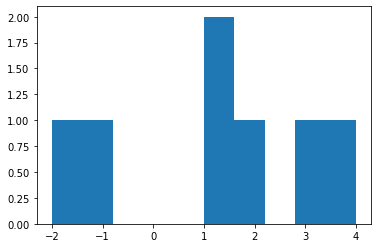

In [15]:
# Quick Test for the Refined Search
iters = 1
results = []
var = []
for xy in db.xy.unique():
    fs = get_focus_stack(db, xy)

    for i in range(iters):
        tf = RefinedStepClimb(fs, imgs, Focus.brenner)
        final = tf.climb(initial_step=10, final_step=2, refinements=5, log=True)
        results.append(get_closest_z(final, fs, imgs)-fs.focus.values[0])
        if i%10<1:
            print(f"Progress: {i} iterations of {iters})")
    var.append(np.std(results))
        
plt.hist(results)

(array([1., 0., 0., 0., 0., 2., 2., 0., 0., 2.]),
 array([0.        , 0.19587585, 0.39175169, 0.58762754, 0.78350338,
        0.97937923, 1.17525507, 1.37113092, 1.56700677, 1.76288261,
        1.95875846]),
 <BarContainer object of 10 artists>)

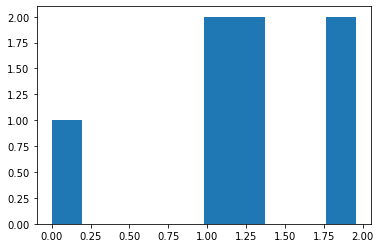

In [16]:
plt.hist(var)

# Region of Interest Focusing

I've had the thought to segment the image and focus the image based on the ROI of near cells. I think this would help remove some of the uncertainty of cells that may be stacked on top of each other. 



### Blob Detection

In [12]:
from skimage import io, img_as_float, filters, morphology
from scipy.ndimage import label, distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import regionprops, regionprops_table





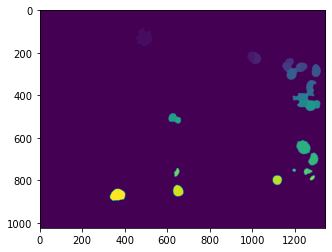

In [121]:
fs = get_focus_stack(db)
tf = RefinedStepClimb(fs, imgs, Focus.brenner)
final = tf.climb(initial_step=10, final_step=2, refinements=5, log=True)
image = get_img_from_z(final, fs, imgs)

close_size=9
open_size=5
watershed_footprint = (13,13)
# Make sure types are the same
input_image = img_as_float(image)

# Filter Image
filtered_image = filters.median(input_image, behavior='ndimage')

# Edge Detection
edge_sobel = filters.sobel(filtered_image)

# Threshold
thresh = filters.threshold_otsu(edge_sobel)
binary_otsu = edge_sobel > thresh

# Binary Morphology Operations
structure_element = morphology.disk(close_size)
closed_image = morphology.binary_closing(binary_otsu, structure_element)
structure_element = morphology.disk(open_size)
opened_image = morphology.binary_opening(closed_image, structure_element)

# Watershed
distance = distance_transform_edt(opened_image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones(watershed_footprint), labels=opened_image)
markers = label(local_maxi)[0]
labels = watershed(-distance, markers, mask=opened_image)

plt.imshow(labels)

regions = regionprops_table(labels, intensity_image=image, properties=('bbox', 'area', 'label', 'centroid', 'max_intensity', 'mean_intensity'))


df = pd.DataFrame(regions)

In [14]:
df.head()

,bbox-0,bbox-1,bbox-2,bbox-3,label,centroid-0,centroid-1,max_intensity,mean_intensity
0,0,359,8,372,1,3.024691,365.074074,524,417.000000
1,0,329,8,340,2,2.937500,334.000000,530,430.156250
2,25,618,72,691,3,47.976932,655.080354,1402,653.895809
3,51,356,74,396,4,63.333333,377.084034,1392,670.991597
4,73,354,97,395,5,83.799274,372.707376,1470,678.648126


In [110]:
def get_roi(img, row_0, col_0, row_1, col_1, pad=10):
    max_row, max_col = img.shape
    
    bbox = [row_0, col_0, row_1, col_1]
    bbox = [int(x) for x in bbox]
    for idx, x in enumerate(bbox):
        
        if x < pad:
            bbox[idx]=0
        else:
            bbox[idx]-=pad
        
        if idx%2==0:
            max_x = max_row
        else:
            max_x = max_col
        
        if x+pad > max_x:
            bbox[idx]=max_x
        else:
            bbox[idx]=x+pad
    
    return img[bbox[0]:bbox[2], bbox[1]:bbox[3]]



In [18]:
%config IPCompleter.greedy=True



In [16]:
get_roi(image, 85,451,170,530)

array([[109, 107, 108, ..., 103, 106, 105],
       [103, 105, 104, ..., 104, 104, 102],
       [103, 103, 107, ..., 107, 100, 102],
       ...,
       [328, 329, 358, ..., 365, 365, 345],
       [345, 342, 349, ..., 352, 345, 328],
       [404, 390, 362, ..., 367, 356, 360]], dtype=uint16)

In [21]:
fs = get_focus_stack(db)

In [124]:
data = {'score':[], 'position':[], 'label':[]}
temp = df[df['area']>600]
for idx, row in fs.iterrows():
    img = imgs[idx]
    
    for jdx, blob in temp.iterrows():
        roi = get_roi(img, blob['bbox-0'],blob['bbox-1'],blob['bbox-2'],blob['bbox-3'], pad=100)
        sc = Focus.brenner(roi)
        data['score'].append(sc)
        data['position'].append(row.z)
        data['label'].append(blob.label)


In [125]:
data_df = pd.DataFrame.from_dict(data)

In [129]:
data_df['max_focus']=0
data_df = data_df.sort_values(by=['position'])

In [130]:
mx = []
for roi in data_df['label'].unique():
    temp = data_df[data_df['label']==roi]
    if not temp.score.any():
        continue
        print(roi)
    data_df.loc[temp.index, 'max_focus'] = temp.loc[temp.score.idxmax(), 'position']
    mx.append(temp.loc[temp.score.idxmax(), 'position'])

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 1.]),
 array([9292.  , 9293.66, 9295.32, 9296.98, 9298.64, 9300.3 , 9301.96,
        9303.62, 9305.28, 9306.94, 9308.6 , 9310.26, 9311.92, 9313.58,
        9315.24, 9316.9 , 9318.56, 9320.22, 9321.88, 9323.54, 9325.2 ,
        9326.86, 9328.52, 9330.18, 9331.84, 9333.5 , 9335.16, 9336.82,
        9338.48, 9340.14, 9341.8 , 9343.46, 9345.12, 9346.78, 9348.44,
        9350.1 , 9351.76, 9353.42, 9355.08, 9356.74, 9358.4 , 9360.06,
        9361.72, 9363.38, 9365.04, 9366.7 , 9368.36, 9370.02, 9371.68,
        9373.34, 9375.  , 9376.66, 9378.32, 9379.98, 

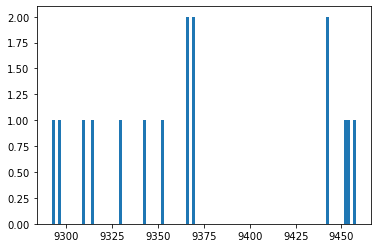

In [131]:
plt.hist(mx, bins=100)

<AxesSubplot:xlabel='position', ylabel='score'>

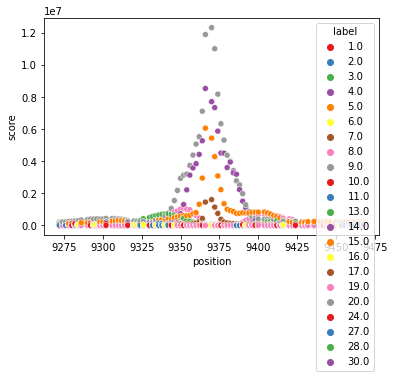

In [132]:
sns.scatterplot(x='position', y='score', hue='label', data=data_df, palette='Set1')

### Extracting Data from Power Point Slides

Each slide contains a .GIF that I want to analyze. 

In [35]:
from L4.FileIO import get_data_filename

presentation = r"D:\WorkDrive\Genotyping\Data\10-30-2020 Cell Data\SingleCellData.pptx_00000 - Copy.pptx"
filename=presentation
data_out = r"D:\Research\ACES\Focus\GIF"

In [218]:
#From @scanny, https://stackoverflow.com/questions/52491656/extracting-images-from-presentation-file
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE

def extract_gifs_from_ppt(filename, output_folder, output_prefix):
    """
    By default, the automated program stores videos of the injection process for single cells and places them into a powerpoint.
    This function reads that powerpoint file, finds all the gifs, and outputs them to a separate folder. Each gif will be 
    labelled serially, (prefix, prefix_00000, prefix_000001, ...). 
    """
    def iter_picture_shapes(prs):
        for slide in prs.slides:
            for shape in slide.shapes:
                if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
                    yield shape

    for picture in iter_picture_shapes(Presentation(filename)):
        image = picture.image
        if image.ext != 'gif':
            continue
        # ---get image "file" contents---
        image_bytes = image.blob
        # ---make up a name for the file, e.g. 'image.jpg'---
        image_filename = get_data_filename(output_prefix, output_folder, extension='.gif')
        with open(image_filename, 'wb') as f:
            f.write(image_bytes)

In [222]:
import imageio
filename = r"D:\Research\ACES\Focus\GIF\cell_injection.gif"
vid = imageio.get_reader(filename,  'ffmpeg')

for num, image in vid.iter_data():
    print(image.mean())

metadata = vid.get_meta_data()

ImportError: To use the imageio ffmpeg plugin you need to 'pip install imageio-ffmpeg'

D:\Software\MiniConda\envs\CEpy3\lib\site-packages\pims\pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


Frame([[[180, 180, 180],
        [173, 173, 173],
        [168, 168, 168],
        ...,
        [160, 160, 160],
        [159, 159, 159],
        [161, 161, 161]],

       [[178, 178, 178],
        [180, 180, 180],
        [175, 175, 175],
        ...,
        [158, 158, 158],
        [163, 163, 163],
        [164, 164, 164]],

       [[191, 191, 191],
        [181, 181, 181],
        [181, 181, 181],
        ...,
        [154, 154, 154],
        [166, 166, 166],
        [162, 162, 162]],

       ...,

       [[157, 157, 157],
        [156, 156, 156],
        [153, 153, 153],
        ...,
        [179, 179, 179],
        [179, 179, 179],
        [173, 173, 173]],

       [[170, 170, 170],
        [165, 165, 165],
        [164, 164, 164],
        ...,
        [166, 166, 166],
        [165, 165, 165],
        [167, 167, 167]],

       [[186, 186, 186],
        [181, 181, 181],
        [177, 177, 177],
        ...,
        [158, 158, 158],
        [158, 158, 158],
        [163, 163, 163]]], dtype=uint8)
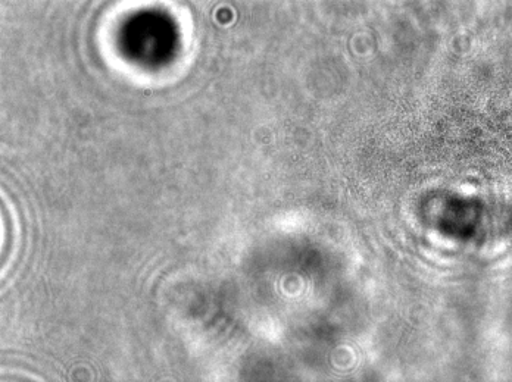

In [3]:
import pims
filename = r"D:\Research\ACES\Focus\GIF\cell_injection.gif"

v = pims.Video(filename)
v[-1]  # a 2D numpy array representing the last frame

### Create a UI that allows us to quickly label a set of images. 

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(4, 1)
ax_im = fig.add_subplot(gs[0:3])
im = ax_im.imshow(v[0], animated=True)
ax_foc = fig.add_subplot(gs[3])
scores = get_gif_focus_array(v)
plot1, = ax_foc.plot(scores)
line1, = ax_foc.plot([0,0], [min(scores), max(scores)])
v_idx = 0
current_idx = 0
gif_idx = 0
current_gif_idx = 0

def get_gif_focus_array(frames, focus_func=Focus.brenner):
    scores = []
    for frame in frames:
        scores.append(focus_func(frame))
    return scores

def updatefig(*args):
    global v_idx, current_idx, gif_idx,  current_gif_idx, v
    if v_idx != current_idx:
        current_idx = v_idx
        im.set_array(v[v_idx])
        line1.set_xdata([v_idx, v_idx])


        ax_foc.set_ylim(min(scores)*0.9, max(scores)*1.1)
    return im, plot1, line1

def on_scroll(event):
    global v_idx
    if event.button == 'up':
        v_idx +=1
    elif event.button == 'down':
        v_idx -=1
    
    if v_idx <0:
        v_idx = 0
    elif v_idx >= len(v):
        v_idx = len(v)-1

    
cid2 = fig.canvas.mpl_connect('scroll_event', on_scroll)   


ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

In [8]:
%matplotlib qt

In [36]:
gif_imgs = [x for x in glob.glob(data_out+'\*.gif')]

In [49]:
v

<Frames>
Format: GIF (Graphics Interchange Format)
Source: D:\Research\ACES\Focus\GIF\cell_injection_00002.gif
Duration: 21.400 seconds
Frame rate: 10.000 fps
Length: 214 frames
Frame Shape: (260, 348, 3)

hi
holo
hi
holo


In [18]:
v

<Frames>
Format: GIF (Graphics Interchange Format)
Source: D:\Research\ACES\Focus\GIF\cell_injection.gif
Duration: 21.200 seconds
Frame rate: 10.000 fps
Length: 212 frames
Frame Shape: (260, 348, 3)

In [19]:
len(v)

212

In [26]:
v_idx=140